# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [1]:
import utils  # a python module in the same dir as the notebooks
import seaborn as sns

In [2]:
CORPUS_NAME = 'genia'
MODEL_SPEC = '_min2_l10'
FREQ_THRESHOLD = 3

In [3]:
import os
os.chdir(utils.ROOT)  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpus
print('Loading n-gram model')
model = ngramcounting.NgramModel.load_model(CORPUS_NAME, MODEL_SPEC)

if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())

Loading n-gram model
Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:13<00:00, 118.00it/s]


## Question 1: How strong is the association in regular concepts?

In [4]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False, pos_filter='.+n')

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries and filtered out 31898 with the POS-tag filter: .+n


In [5]:
len(cont_concepts)

21723

In [6]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [7]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [8]:
data.head(20)

,bigram,in_concept,pmi,ll,freq
0,"(of, arsenic)",False,2.522915,19.107739,4
1,"(,, similar)",False,-0.347627,0.845113,5
2,"(and, secretion)",False,1.365367,15.650506,11
3,"(,, implicate)",False,0.638141,2.443953,6
4,"(redox, state)",True,6.409419,43.953821,3
5,"(,, dibutyryl)",False,2.295750,12.561360,3
6,"(into, the)",False,1.946253,199.778295,80
7,"(and, atopic)",False,2.049704,10.131690,3
8,"(;, 17)",True,4.803986,38.784870,4
9,"(regulator, ,)",False,0.534762,1.514687,5


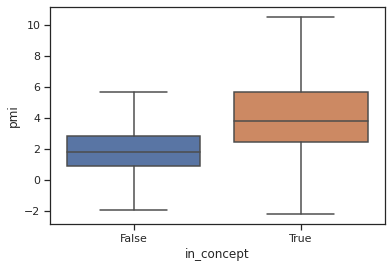

In [9]:
import seaborn as sns
sns.boxplot(x='in_concept', y='pmi', data=data, showfliers=False)

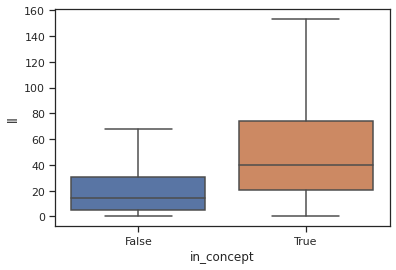

In [10]:
sns.boxplot(x='in_concept', y='ll', data=data, showfliers=False)

In [11]:
# we can perform t-tests etc.

In [12]:
from scipy import stats

In [13]:
import pingouin
pingouin.mwu(data[data['in_concept'] == True]['pmi'],
             data[data['in_concept'] == False]['pmi'])

,U-val,tail,p-val,RBC,CLES
MWU,71580289.5,two-sided,0.0,-0.556,0.778


In [14]:
data.sort_values('ll', ascending=False).tail(50)

,bigram,in_concept,pmi,ll,freq
15090,"(the, transfected)",False,0.015365,1.726829e-03,6
10028,"(the, cell-specific)",False,0.018109,1.711562e-03,4
10413,"(cytokine, with)",False,-0.018186,1.680915e-03,4
3800,"(be, either)",False,0.016555,1.678334e-03,5
19631,"(factor, activation)",True,0.012137,1.631284e-03,10
16341,"(lymphoma, of)",True,0.019659,1.608306e-03,3
4896,"(a, important)",False,-0.014392,1.273561e-03,5
3633,"(a, such)",False,-0.015619,1.250179e-03,4
12770,"(,, reveal)",False,0.011514,1.234733e-03,8
4962,"(to, activation)",False,-0.005945,1.121317e-03,30


Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [15]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [16]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    
    data_dict['type'].append(bigram_type)


data = pd.DataFrame(data_dict)

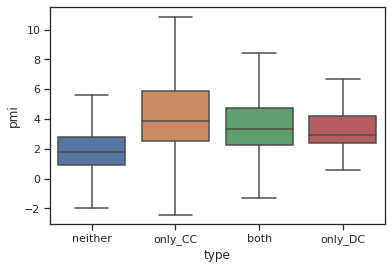

In [17]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

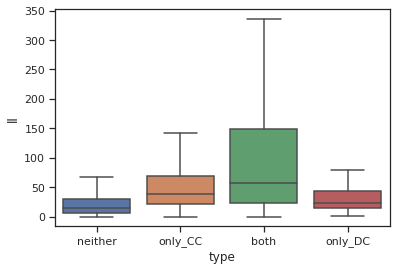

In [18]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [19]:
pingouin.kruskal(data, 'll', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,3,2931.363,0.0


In [20]:
# However, notice that
len(data[data['type'] == 'only_DC'])

25

In [21]:
# compared to e.g.
len(data[data['type'] == 'both'])

777

## Question 3: What is the association across the gap?

In [22]:
from collections import defaultdict
from itertools import product

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
false_bridges = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_tokens()
    norm_concept = dc.normalized_concept()
    spanned_tokens = dc.get_spanned_tokens()
    non_dc_tokens = set(spanned_tokens).difference(tokens)
    for t in non_dc_tokens:
        if t.mapped_pos() == 'c':
            cc = t
            break
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)
            for false_friends in product(non_dc_tokens, [t1, t2]):
                f1, f2 = sorted(false_friends, key=lambda x: x.span[0])
                if f1.span[0] < cc.span[0] < f2.span[0]:
                    false_bridge = (f1.lemma(), f2.lemma())
                    false_bridges[false_bridge].append(dc)
        else:
            cont_bigrams[bigram].append(dc)

In [23]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'type': [], 'in_concept': []}

all_bigrams = set.union(set(gap_bigrams.keys()), set(cont_bigrams.keys()), set(false_bridges.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD and (bigram not in false_bridges or model.freq(bigram) < 1):
        continue

    data_dict['bigram'].append(bigram)
    data_dict['freq'].append(model.freq(bigram))

    contingency_table = model.contingency_table(bigram[0], bigram[1], smoothing=1)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    elif bigram in cont_bigrams:
        type_ = 'only_cont'
    elif bigram in false_bridges and bigram not in concept_bigrams:
        type_ = 'bad'
    else:
        type_ = 'false'
    data_dict['type'].append(type_)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)

data = pd.DataFrame(data_dict)

### NOTE

That a bigram occurs as `only_gap` means that it occurs only in gap position for DC's. However, those bigrams can just as well occur in CC's as well, thereby getting a high association.

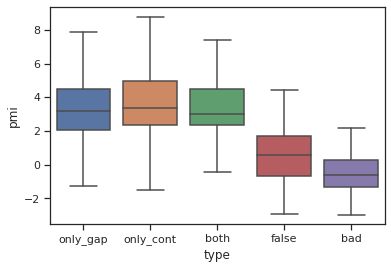

In [24]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

In [25]:
len(data[data['type'] == 'false'])

38

In [26]:
pingouin.kruskal(data, 'pmi', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,4,162.127,5.113204e-34


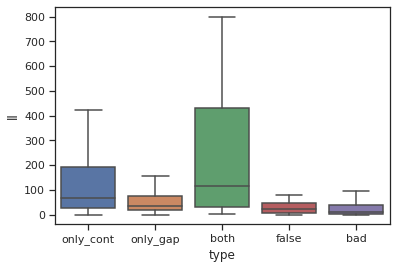

In [40]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [28]:
data[data['type'] == 'false'].sort_values(['pmi', 'll'], ascending=False).head(50)

,bigram,freq,pmi,ll,type,in_concept
183,"(pma-, induced)",3,7.791787,56.290853,false,True
180,"(gamma, delta)",6,5.486072,63.933485,false,True
515,"(myeloid, progenitor)",2,4.405963,20.673641,false,True
318,"(nm23, protein)",4,3.714515,28.708191,false,True
211,"(alpha, globin)",4,3.573091,26.408233,false,True
128,"(dna-binding, protein)",33,3.211070,158.562848,false,True
127,"(gamma, mrna)",2,2.188308,7.852912,false,True
18,"(basal, expression)",3,1.874854,8.356068,false,True
578,"(beta, ()",21,1.736794,41.373830,false,True
880,"(il-1, ))",9,1.684238,17.892525,false,True


## Question 4: What is the full-term unithood?

In [ ]:
sns.lmplot('freq', 'll', data)

In [ ]:
all_concepts = disc_concepts.union(cont_concepts)

In [ ]:
data_dict = {'concept': [], 'type': [],  'pmi_nl': [], 'tc': [], 'freq': [], 'len': []}

for concept in all_concepts:
    
    if model[concept] < FREQ_THRESHOLD:
        continue
    
    data_dict['concept'].append(concept)
    
    data_dict['freq'].append(model[concept])
    
    if concept in disc_concepts:
        if concept in cont_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_DC'
    else:
        concept_type = 'only_CC'
    data_dict['type'].append(concept_type)
    
    data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(concept, model))
    data_dict['tc'].append(conceptstats.term_coherence(concept, model))
    
    data_dict['len'].append(len(concept))


data = pd.DataFrame(data_dict)

In [ ]:
data.sort_values('tc', ascending=False).head(50)

In [ ]:
len(data[(data['pmi_nl'] < 2) & (data['len'] == 2)]) / len(data)

In [ ]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [ ]:
data_dict = {'ngram': [], 'freq': [], 'type': [], 'tc': [], 'pmi_nl': [], 'len': []}

for n in range(2, 11):
    for ngram, count in model.iterate(n, FREQ_THRESHOLD):
        
        ngram = tuple(ngram.split())

        data_dict['ngram'].append(ngram)

        data_dict['freq'].append(model[ngram])

        if ngram in disc_concepts:
            if ngram in cont_concepts:
                ngram_type = 'both'
            else:
                ngram_type = 'only_DC'
        elif ngram in cont_concepts:
            ngram_type = 'only_CC'
        else:
            ngram_type = 'neither'
            
        data_dict['type'].append(ngram_type)

        data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(ngram, model, smoothing=.1))
        data_dict['tc'].append(conceptstats.term_coherence(ngram, model))

        data_dict['len'].append(len(ngram))
        
data = pd.DataFrame(data_dict)

In [ ]:
sns.boxplot(x='type', y='pmi_nl', data=data, showfliers=False)

In [ ]:
pingouin.pairwise_ttests